In [1]:


import pandas as pd
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [2]:
base_dir = '../out/cluster'

### Experiment with the intra pair similarity metric

In [4]:
from utils.cluster.similarity_metrics import intra_pairs, intra_pairs_similarity
from clusim.clustering import Clustering

lhs = Clustering().from_membership_list([0, 0, 1, 1, 1, 2, 3, 3])
rhs = Clustering().from_membership_list([0, 0, 1, 1, 1, 2, 2, 2])

print(f'intra-pairs_old(lhs) -> {" ".join([f"<{l}, {r}>" for l, r in intra_pairs(lhs)])}')
print(f'intra-pairs_old(lhs) -> {" ".join([f"<{l}, {r}>" for l, r in intra_pairs(rhs)])}')
print(f'intra-pairs similarity(lhs, rhs) = {intra_pairs_similarity(lhs, rhs)}')

intra-pairs_old(lhs) -> 
intra-pairs_old(lhs) -> 
intra-pairs similarity(lhs, rhs) = 0.8333333333333334


### Compare different cluster similarity metrics on the same clusters

In [5]:
# Import the data
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from utils.dataset import get_train_test_data
from utils.dataset import get_data_masks
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from utils.cluster.ClusteringMode import LocalLatentMode
from xplique.attributions import GradCAMPP
from utils.general import beep
from utils.cluster.visualize import visualize_clusters_projections
from datetime import datetime

print('Preparing the environment ...')
# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=False)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

# load the model
classifier = tf.keras.models.load_model('../in/digit_classifier')

# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=False)

# create the approach corresponding to the best configuration
approach = LocalLatentMode(
    mask=mask_label,
    explainer=GradCAMPP(classifier),
    clus_tech=AffinityPropagation(),
    dim_red_techs=[TSNE(perplexity=3)]
)
print('Collecting the data ...')
data = []
for _ in range(50):
    contributions = approach.generate_contributions(test_data, predictions_cat)
    clusters, score, projections = approach.cluster_contributions(contributions)
    data.append({
        'timestamp': datetime.now(),
        'clusters': clusters,
        'score': score,
        'projections': projections
    })
solutions = pd.DataFrame(data)
beep()

2022-04-12 09:42:01.655126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Preparing the environment ...


<AxesSubplot:ylabel='score'>

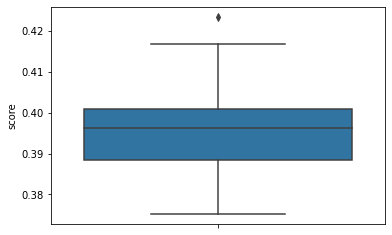

In [6]:
import seaborn as sns
sns.boxplot(data=solutions, y='score')

Visualizing the clusters


(<Figure size 1152x648 with 1 Axes>, <AxesSubplot:>)

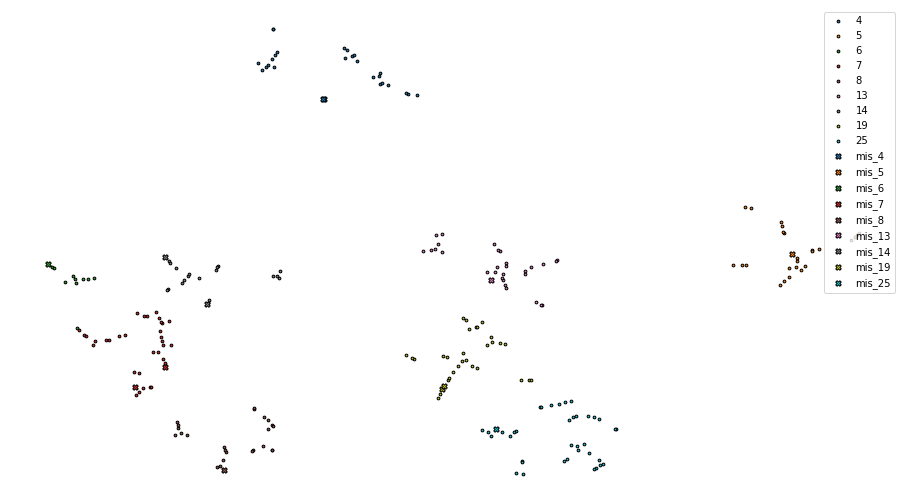

In [7]:
# create the mask for the misclassified items of the selected label
mask_miss_label = mask_miss[mask_label]
# create the mask for the clusters containing misclassified elements of the selected label
mask_contains_miss_label = np.isin(clusters, np.unique(clusters[mask_miss_label]))

print('Visualizing the clusters')
# visualize the projections of the contributions for the correct predictions
fig, ax = visualize_clusters_projections(
    projections=projections[~mask_miss_label & mask_contains_miss_label],
    clusters=clusters[~mask_miss_label & mask_contains_miss_label],
    cmap='tab10', marker='.'
)
# visualize the projections of the contributions for the wrong predictions
visualize_clusters_projections(
    projections=projections[mask_miss_label],
    clusters=clusters[mask_miss_label],
    fig=fig, ax=ax, cmap='tab10', marker='X', label_prefix='mis'
)

In [8]:
from clusim.clustering import Clustering
from utils.cluster.similarity_metrics import intra_pairs_similarity
from clusim.sim import jaccard_index, nmi, element_sim, adjrand_index, fowlkes_mallows_index, fmeasure, purity_index, classification_error, czekanowski_index, dice_index, sorensen_index, rogers_tanimoto_index, pearson_correlation, sample_expected_sim, geometric_accuracy, overlap_quality, onmi, omega_index, rand_index, southwood_index
from itertools import combinations

similarity_metrics = [
    (jaccard_index, 'jaccard_index'),
    (rand_index, 'rand_index'),
    (adjrand_index, 'adjrand_index'),
    (fowlkes_mallows_index, 'fowlkes_mallows_index'),
    (fmeasure, 'fmeasure'),
    (purity_index, 'purity_index'),
    (classification_error, 'classification_error'),
    (czekanowski_index, 'czekanowski_index'),
    (dice_index, 'dice_index'),
    (sorensen_index, 'sorensen_index'),
    (rogers_tanimoto_index, 'rogers_tanimoto_index'),
    (southwood_index, 'southwood_index'),
    (pearson_correlation, 'pearson_correlation'),
    # (corrected_chance, 'corrected_chance'),
    (sample_expected_sim, 'sample_expected_sim'),
    (nmi, 'nmi'),
    # (mi, 'mi'),
    # (adj_mi, 'adj_mi'),
    # (rmi, 'rmi'),
    # (vi, 'vi'),
    (geometric_accuracy, 'geometric_accuracy'),
    (overlap_quality, 'overlap_quality'),
    (onmi, 'onmi'),
    (omega_index, 'omega_index'),
    (element_sim, 'element_sim'),
    (intra_pairs_similarity, 'intra_pairs')
]

data = []
# find all the possible combinations of solutions
pairs = list(combinations(solutions['clusters'], 2))
for metric, metric_name in similarity_metrics:
    print(f'Collecting data for {metric_name} ...')
    similarities =[metric(Clustering().from_membership_list(lhs), Clustering().from_membership_list(rhs)) for lhs, rhs in pairs]
    data.append({
        'metric': metric_name,
        'similarities': similarities,
        'avg_similarity': np.average(similarities)
    })
compared_metrics = pd.DataFrame(data)
beep()

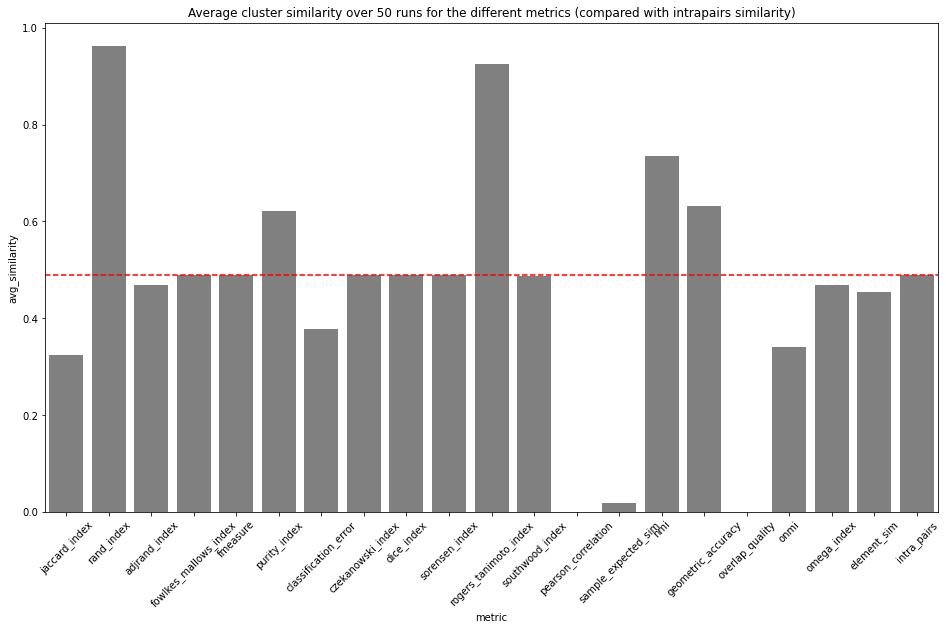

In [12]:
from utils.general import save_figure
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 9))
ax = sns.barplot(data=compared_metrics, x='metric', y='avg_similarity', color='grey')
plt.axhline(compared_metrics[compared_metrics['metric'] == 'intra_pairs']['avg_similarity'].iloc[0], color='red', linestyle='dashed')
plt.xticks(rotation=45);
ax.set_title('Average cluster similarity over 50 runs for the different metrics (compared with intrapairs similarity)')
save_figure(fig, '../out/cluster_similarity/average_similarity')

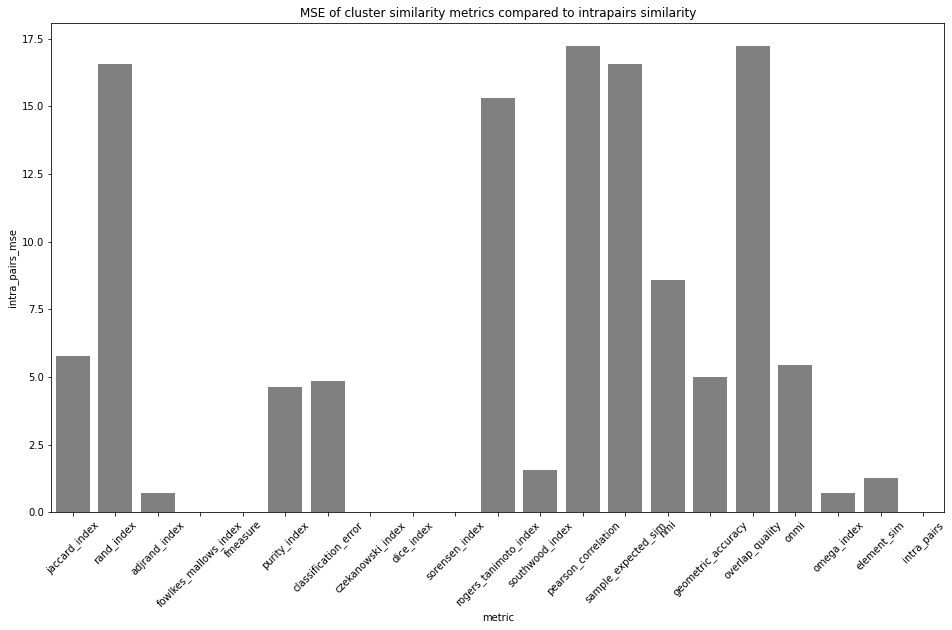

In [14]:
intra_pairs_similarity = np.array(compared_metrics[compared_metrics['metric'] == 'intra_pairs']['similarities'].iloc[0])
compared_metrics['intra_pairs_mse'] = compared_metrics.apply(lambda row: np.sqrt(np.sum((np.array(row['similarities']) - intra_pairs_similarity) ** 2)), axis=1)
fig = plt.figure(figsize=(16, 9))
ax = sns.barplot(data=compared_metrics, x='metric', y='intra_pairs_mse', color='grey')
plt.xticks(rotation=45);
ax.set_title('MSE of cluster similarity metrics compared to intrapairs similarity')
save_figure(fig, '../out/cluster_similarity/mse')

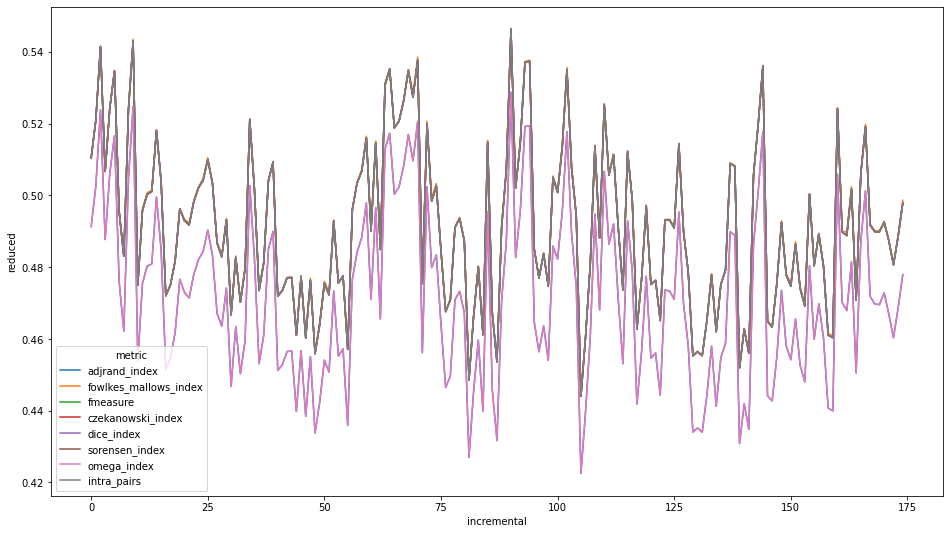

In [147]:
from utils.general import shorten_list

compared_metrics['reduced'] = compared_metrics['similarities'].apply(lambda l: shorten_list(np.array(l), 200))
exploded = compared_metrics[compared_metrics['intra_pairs_mse'] < 1].explode('reduced').reset_index(drop=True)
exploded['incremental'] = exploded.groupby('metric').cumcount()
plt.figure(figsize=(16, 9))
sns.lineplot(data=exploded, x='incremental', y='reduced', hue='metric')
beep()